## Here I will be attempting to create a generalized truss solver

In [3]:
# Dependencies
import copy 
import math
import numpy as np
import matplotlib.pyplot as plt
 

## Structure data entry

In [5]:
# Constants
E = 200*10**9 # (N/m^2)
A = 0.005 #(m^2)
xFac = 50 # Scale factor for plotted displacement

# Nodal Coordinates [x,y] (in ascending node order)
nodes = np.array([[0,0],
                  [5,8.66],
                  [15,8.66],
                  [20,0],
                  [10,0],
                  [10,-5]])

# members [node_i , node_j]
members = np.array([[1,2],
                    [2,3],
                    [3,4],
                    [4,5],
                    [1,5],
                    [2,5],
                    [3,5],
                    [5,6]])

# Supports
restrainedDoF = [7,8,11,12] # The degreees of freedom estrained by supports

# Loading
forceVector = np.array([[0,-200000,0,0,0,0,0,0,0,0,0,0]]).T # Vector of externally applied loads

# ============================= End of Data Entry =============================

## Calculate member orientation and length

In [7]:
# Define a member to calculate the member orientation and length
def memberOrientation(memberNo):
    memberIndex = memberNo - 1 #index identifying member in the array of members
    node_i = members[memberIndex][0]
    node_j = members[memberIndex][1]

    xi = nodes[node_i - 1][0] #x-coordinate of node i
    yi = nodes[node_i - 1][1] #y-coordinate of node i
    xj = nodes[node_j - 1][0] #x-coordinate of node j
    yj = nodes[node_j - 1][1] #y-coordinate of node j

    # Angle of member with repect to horizonta; axis

    dx = xj - xi # x-component of member vector
    dy = yj - yi # y-component of member vector
    mag = math.sqrt(dx**2 + dy**2) # Magnitude of the vector (Length of the member)
    memberVector = np.array([dx , dy]) # Mmeber representated as a vector

    # We have to find the quadrant in which the member is present and then find the appropriate reference axis and offset angle
    if(dx>0 and dy==0):
        theta = 0
    elif(dx==0 and dy>0):
        theta = math.pi/2
    elif(dx<0 and dy==0):
        theta = math.pi
    elif(dx==0 and dy<0):
        theta = 3*math.pi/2
    elif(dx>0 and dy>0):
        #First Quadrant
        refVector = np.array([1,0]) #Vector describing the positive x-axis
        theta = math.acos(refVector.dot(memberVector)/mag) #Standard formula for the angle between 2 vectors
    elif(dx<0 and dy>0):
        #Second Quadrant
        refVector = np.array([0,1])
        theta = (math.pi/2) + math.acos(refVector.dot(memberVector)/mag)
    elif(dx<0 and dy<0):
        #Third Quadrant
        refVector = np.array([-1,0])
        theta = math.pi + math.acos(refVector.dot(memberVector)/mag)
    elif(dx>0 and dy<0):
        #Fourth quadrant
        refVector = np.array([0,-1])
        theta = 3*math.pi/2 + math.acos(refVector.dot(memberVector)/mag)
        
    return [theta,mag]
        

In [8]:
# Calculating orientation and length for each member and store
orientations = np.array([]) #Initialize an array to hold arientation
lengths = np.array([]) #Initialize an array to hold lengths

for n,mdr in enumerate(members):
    [angle,leng] = memberOrientation(n+1)
    orientations = np.append(orientations,angle)
    lengths = np.append(lengths, leng)


## Define a function to calculate member global stiffness matrix 

In [10]:
#Define a function to calculate the global stiffness matrix of an axially loaded bar
def calculateKg(memberNo):
    """
    Calculate the global stiffness matrix for an axially loaded bar
    memberNo: The member number 
    """    
    theta = orientations[memberNo-1]
    mag = lengths[memberNo-1]
        
    c = math.cos(theta)
    s = math.sin(theta)
    
    K11 = (E*A/mag)*np.array([[c**2,c*s],[c*s,s**2]]) #Top left quadrant of global stiffness matrix
    K12 = (E*A/mag)*np.array([[-c**2,-c*s],[-c*s,-s**2]]) #Top right quadrant of global stiffness matrix   
    K21 = (E*A/mag)*np.array([[-c**2,-c*s],[-c*s,-s**2]]) #Bottom left quadrant of global stiffness matrix   
    K22 = (E*A/mag)*np.array([[c**2,c*s],[c*s,s**2]]) #Bottom right quadrant of global stiffness matrix          
    
    return [K11, K12, K21,K22]

## Build the primary stiffness matrix, Kp

In [12]:
nDoF = np.amax(members)*2 # Total number of degrees of freedom
Kp = np.zeros([nDoF,nDoF]) # Initialising the primary stiffness matrix

for n,mbr in enumerate(members):
    [K11 , K12 , K21 , K22] = calculateKg(n+1)
    node_i = mbr[0] #Node number for node i of this member
    node_j = mbr[1] #Node number for node j of this member

    ia = 2*node_i - 2
    ib = 2*node_i - 1
    ja = 2*node_j - 2
    jb = 2*node_j - 1

    Kp[ia:ib+1 , ia:ib+1] = Kp[ia:ib+1 , ia:ib+1] + K11
    Kp[ia:ib+1 , ja:jb+1] = Kp[ia:ib+1 , ja:jb+1] + K12
    Kp[ja:jb+1 , ia:ib+1] = Kp[ja:jb+1 , ia:ib+1] + K21
    Kp[ja:jb+1 , ja:jb+1] = Kp[ja:jb+1 , ja:jb+1] + K22


## Extract the structure stiffness matrix

In [14]:
restrainedIndex = [x - 1 for x in restrainedDoF] #Index for each restrained DoF (list comprehension)

#Reduce to structure stiffness matrix by deleting rows and columns for restrained DoF
Ks = np.delete(Kp,restrainedIndex,0) #Delete rows
Ks = np.delete(Ks,restrainedIndex,1) #Delete columns
Ks = np.matrix(Ks) # Convert Ks from numpy.ndarray to numpy.matrix to use build in inverter function

## Solve for displacement

In [16]:
forceVectorRed = copy.copy(forceVector)
forceVectorRed = np.delete(forceVectorRed , restrainedIndex , 0)
U = Ks.I*forceVectorRed

## Solve for reactions

In [18]:
# Construct the global displacement vector
UG = np.zeros(nDoF)

c = 0
for i in np.arange(nDoF):
    if i in restrainedIndex:
        UG[i] = 0
    else:
        UG[i] = U[c]
        c += 1

UG = np.array([UG]).T
FG = np.matmul(Kp, UG)


C:\Users\Chaitanya Ghodmare\AppData\Local\Temp\ipykernel_2520\1327295914.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  UG[i] = U[c]


## Solve for member forces

In [20]:
mbrForces = np.array([]) # initialise an array to hold member forces

for n,mbr in enumerate(members):
    theta = orientations[n]
    mag = lengths[n]

    node_i = mbr[0]
    node_j = mbr[1]

    ia = 2*node_i - 2
    ib = 2*node_i - 1
    ja = 2*node_j - 2
    jb = 2*node_j - 1

    # Transformation matrix
    c = math.cos(theta)
    s = math.sin(theta)
    T = np.array([[c,s,0,0],[0,0,c,s]])

    disp = np.array([[UG[ia] , UG[ib] , UG[ja] , UG[jb]]]).T
    disp_local = np.matmul(T,disp)[0]
    F_axial = (A*E/mag)*(disp_local[1] - disp_local[0]) #Axial load

    mbrForces = np.append(mbrForces , F_axial) #Store axial loads




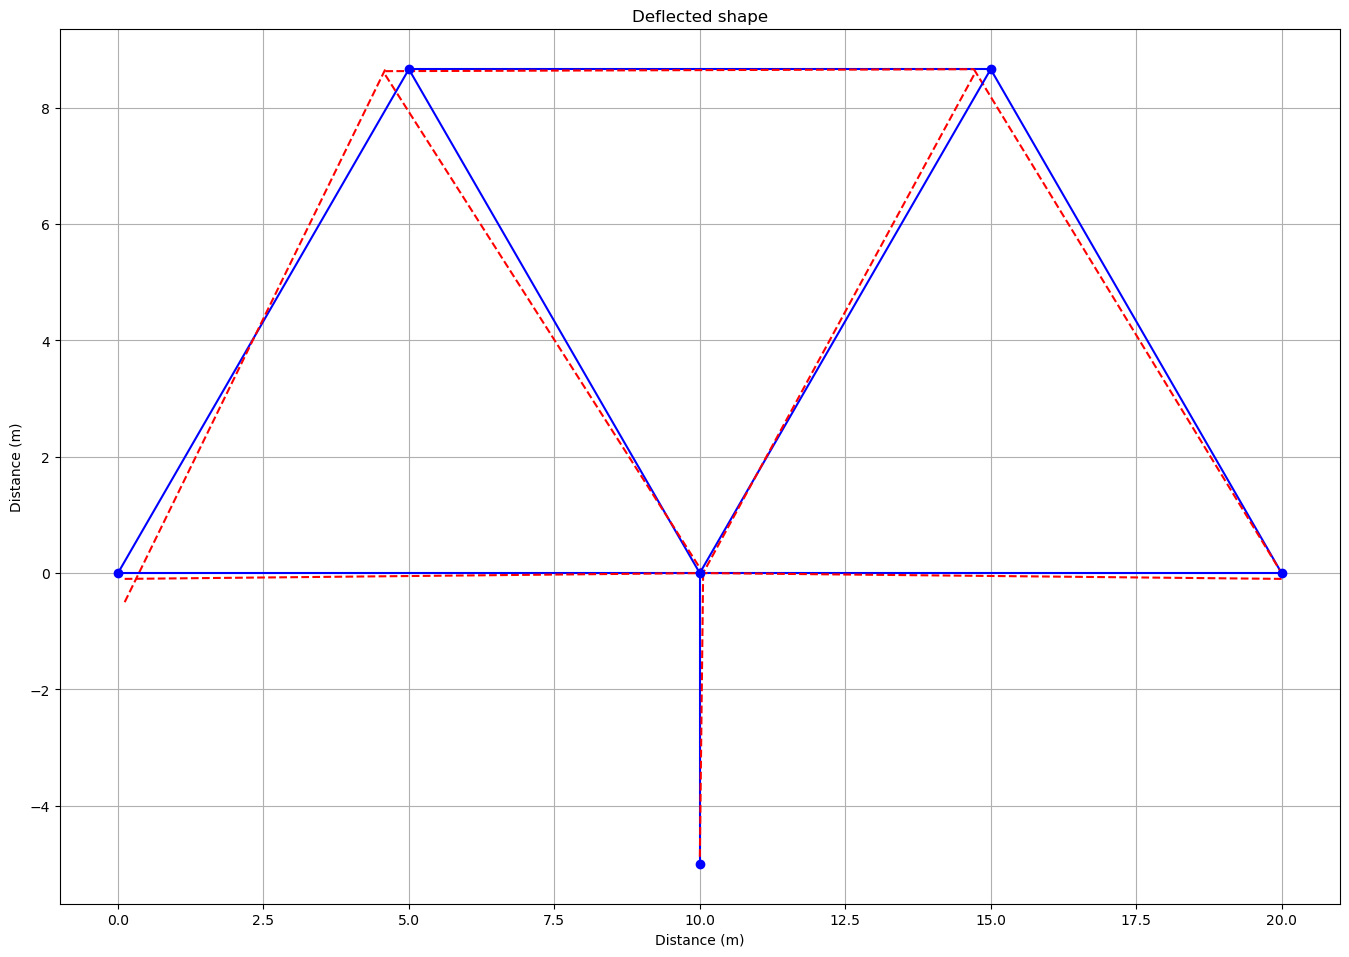

In [38]:
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,2,2])
fig.gca().set_aspect('equal' , adjustable= 'box')

# Plot members
for mbr in members:
    node_i = mbr[0] # Node number for node i of this member
    node_j = mbr[1] # Node number for node j of this member

    ix = nodes[node_i-1 , 0] # x-coordinate if node i of this member
    iy = nodes[node_i-1 , 1] # y-coordinate if node i of this member
    jx = nodes[node_j-1 , 0] # x-coordinate if node j of this member
    jy = nodes[node_j-1 , 1] # y-coordinate if node j of this member

    # Index of DoF for this member
    ia = 2*node_i - 2 #horizontal DoF at the node i for this member
    ib = 2*node_i - 1 #vertical DoF at node i for this member
    ja = 2*node_j - 2 #horizontal DoF at the node j for this member
    ib = 2*node_j - 1 #vertical DoF at node j  for this member

    axes.plot([ix,jx] , [iy,jy] , 'b')
    axes.plot([ix + UG[ia,0]*xFac, jx + UG[ja,0]*xFac], [iy + UG[ib,0]*xFac, jy + UG[jb,0]*xFac],'--r')

# Plot nodes
for node in nodes:
    axes.plot([node[0]] , [node[1]] , 'bo')

axes.set_xlabel('Distance (m)')
axes.set_ylabel('Distance (m)')
axes.set_title('Deflected shape')
axes.grid()
plt.show()

## Summary output

In [45]:
#Generate output statements
print("REACTIONS")
for i in np.arange(0,len(restrainedIndex)):           
    index = restrainedIndex[i]
    print("Reaction at DoF {one}: {two} kN".format(one = index+1, two = round(FG[index].item()/1000,2)))

print("")   
print("MEMBER FORCES")    
for n, mbr in enumerate(members):    
    print("Force in member {one} (nodes {two} to {three}) is {four} kN".format(one = n+1, two=mbr[0], three=mbr[1], four=round(mbrForces[n]/1000,2)))

print("")   
print("NODAL DISPLACEMENTS") 
for n, node in enumerate(nodes):    
    ix = 2*(n+1)-2 #horizontal DoF for this node
    iy = 2*(n+1)-1 #vertical DoF for this node
    
    ux = round(UG[ix,0],5) #Horizontal nodal displacement
    uy = round(UG[iy,0],5) #Vertical nodal displacement
    print("Node {one}: Ux = {two} m, Uy = {three} m".format(one=n+1, two=ux, three=uy))

REACTIONS
Reaction at DoF 7: 0.0 kN
Reaction at DoF 8: -200.0 kN
Reaction at DoF 11: 0.0 kN
Reaction at DoF 12: 400.0 kN

MEMBER FORCES
Force in member 1 (nodes 1 to 2) is 230.94 kN
Force in member 2 (nodes 2 to 3) is 230.95 kN
Force in member 3 (nodes 3 to 4) is 230.94 kN
Force in member 4 (nodes 4 to 5) is -115.47 kN
Force in member 5 (nodes 1 to 5) is -115.47 kN
Force in member 6 (nodes 2 to 5) is -230.94 kN
Force in member 7 (nodes 3 to 5) is -230.94 kN
Force in member 8 (nodes 5 to 6) is -400.0 kN

NODAL DISPLACEMENTS
Node 1: Ux = 0.00231 m, Uy = -0.01867 m
Node 2: Ux = -0.00808 m, Uy = -0.01 m
Node 3: Ux = -0.00577 m, Uy = -0.00067 m
Node 4: Ux = 0.0 m, Uy = 0.0 m
Node 5: Ux = 0.00115 m, Uy = -0.002 m
Node 6: Ux = 0.0 m, Uy = 0.0 m
